C:\Users\Joe Fritch\Anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


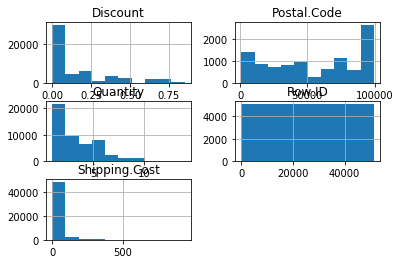

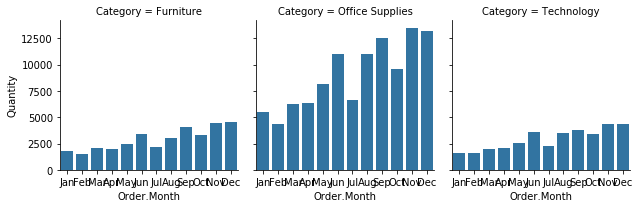

In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

# cd Documents/NYC\ Data\ Science\ Academy/Week\ 8/feb25/ML_Lab
# cd ~/Documents/NYC\ Data\ Science\ Academy/Week\ 8/feb25/ML_Lab

Orders = pd.read_csv("data/Orders.csv")
#Returns = pd.read_csv("data/Returns.csv")

Orders.hist()
#Orders.hist()
Orders.columns
################################  PART 1 ######################################
##############################  PROBLEM 1 #####################################
columns = ['Profit', 'Sales']
for col in columns:
    Orders[col] = Orders[col].str.replace("[$,]","").astype("float")
del (col, columns)
Orders.dtypes
columns = ['Order.Date', 'Ship.Date']
for col in columns:
    Orders[col] = pd.to_datetime(Orders[col], infer_datetime_format = True).dt.date
del (col, columns)
##############################  PROBLEM 2 #####################################
# Problem 2, Question 1
Orders['Order.Month'] = pd.Series(list(map(lambda x: x.month, Orders['Order.Date'])))
monthly_orders = Orders.groupby("Order.Month").agg({"Quantity": "sum"})
Months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
monthly_orders.index = Months
sns.barplot(x = monthly_orders.index, y = monthly_orders['Quantity'])
#sns.barplot(x = monthly_orders.index, y = monthly_orders['Quantity'])

# Problem 2, Question 2
monthly_cat_orders = Orders.groupby(["Order.Month" ,"Category"]).agg({"Quantity": "sum"})
monthly_cat_orders = monthly_cat_orders.reset_index(level = "Category")
monthly_cat_orders.index =  pd.Index(np.repeat(Months, 3), name = monthly_cat_orders.index.name)
monthly_cat_orders.reset_index(inplace = True)

fg = sns.FacetGrid(monthly_cat_orders, col = "Category")
fg = fg.map(sns.barplot, "Order.Month", 'Quantity')
#fg = sns.FacetGrid(monthly_cat_orders, col = "Category")
#fg = fg.map(sns.barplot, "Order.Month", 'Quantity')


##############################  PROBLEM 3 #####################################
Returns = pd.read_csv("data/Returns.csv")
merged_returns = pd.merge(Orders, Returns, how = "inner", left_on = "Order.ID",
                  right_on = "Order ID").drop(["Order ID", "Region_y"], axis = 1)
# Problem 3, Question 1
merged_returns['Profit'].sum()
# $61370.75 in profits returned
# Problem 3, Question 2
name_count = {}
for name in merged_returns['Customer.Name']:
    name_count[name] = sum(merged_returns['Customer.Name'].str.find(name) != -1)
len({key:value for (key, value) in name_count.items() if value > 1})
# 449 customers returned more than one time
len({key:value for (key, value) in name_count.items() if value > 5})
# 124 customers returned more than five times
# Problem 3, Question 3
merged_returns['Region_x'].value_counts()
# Problem 3, Question 4
merged_returns['Sub.Category'].value_counts()
################################  PART 2 ######################################
##############################  PROBLEM 4 #####################################

## Step 1
#Orders['Order.ID'].isin(Returns['Order ID'])
merged_returns = pd.merge(Orders, Returns, how = "outer", left_on = "Order.ID",
                  right_on = "Order ID").drop(["Order ID", "Region_y"], axis = 1)
merged_returns['Returned'].fillna("No", inplace = True)


## Step 2
merged_returns['Process.Time'] = merged_returns['Ship.Date'] - merged_returns['Order.Date']


#np.sub()
#list(map(lambda x: x.day, Orders['Ship.Date']))  list(map(lambda x: x.day, Orders['Order.Date']))


# Step 3
merged_returns[merged_returns['Returned'] == "Yes"].groupby('Product.ID').agg({'Quantity':'sum'})
tmp = merged_returns.groupby(['Product.ID', 'Returned']).agg({'Quantity': "sum"}).reset_index(['Returned','Product.ID'])
tmp = tmp.rename(columns = {"Quantity": "Quantity.Returned"})

for row in range(0, len(tmp)):
    if (tmp.loc[row, 'Returned'] == "No"):
        tmp.loc[row, 'Quantity.Returned'] = 0

merged_returns = pd.merge(merged_returns, tmp, how = "outer", left_on = ["Product.ID", "Returned"],
         right_on = ["Product.ID", "Returned"])





In [43]:
# If city shows up <= 50 times, categorize as "Other"
others = list(merged_returns['City'].value_counts().index[merged_returns['City'].value_counts() <= 50])
merged_returns['City'] = ['Other' if x in others else x for x in merged_returns['City']]

# If state shows up <= 25 times, categorize as "Other"
others = list(merged_returns['State'].value_counts().index[merged_returns['State'].value_counts() <= 25])
merged_returns['State'] = ['Other' if x in others else x for x in merged_returns['State']]

# If country shows up <= 10 times, categorize as "Other"
others = list(merged_returns['Country'].value_counts().index[merged_returns['Country'].value_counts() <= 10])
merged_returns['Country'] = ['Other' if x in others else x for x in merged_returns['Country']]


# Keeping Customer ID over Customer Name, in case there are two customers with the same name
# Product ID is probably more reliable than Product Name, but same information
# Postal code has many NAs, probably too granular for this purpose anyway
# Customer's probably aren't going to consider a company's profits when making a return
drop_columns = ['Row.ID', 'Order.ID', 'Customer.Name',
                'Postal.Code', 'Market', 'Product.Name',
                'Profit']

merged_returns.drop(columns = drop_columns, inplace= True)

y = merged_returns['Returned']

In [40]:
##############################  PROBLEM 5 #####################################
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import sklearn.cross_validation as cv

#Categorical Variable DF
CAT_DF = merged_returns[['Ship.Mode','Customer.ID','Segment',
                        'City','State','Country','Region_x',
                       'Product.ID','Category', 'Sub.Category',
                       'Order.Priority']]

#Dummify
dummy_df = pd.get_dummies(CAT_DF, prefix=['Ship.Mode','Customer.ID','Segment',
                    'City','State','Country','Region_x',
                  'Product.ID','Category','Sub.Category','Order.Priority'])

#train_fe = train_fe.drop('Exterior2nd', axis = 1)

merged_return = merged_returns[['Order.Date','Ship.Date','Sales','Quantity','Discount',
                               'Shipping.Cost']]

return_df = pd.concat([merged_return, dummy_df], axis=1, sort=False)
return_df.head()





Order.Date   Ship.Date   Sales  Quantity  Discount  Shipping.Cost  \
0  2014-11-11  2014-11-13  221.98         2      0.00          40.77   
1  2013-03-05  2013-03-09  466.16         7      0.40          32.98   
2  2014-11-11  2014-11-13  341.96         2      0.00          25.27   
3  2015-07-01  2015-07-03  436.00         3      0.15          52.12   
4  2013-12-20  2013-12-25  359.06         3      0.30          22.18   

   Ship.Mode_First Class  Ship.Mode_Same Day  Ship.Mode_Second Class  \
0                      1                   0                       0   
1                      0                   0                       0   
2                      1                   0                       0   
3                      0                   0                       1   
4                      0                   0                       0   

   Ship.Mode_Standard Class          ...            Sub.Category_Machines  \
0                         0          ...                                0   
1                         1          ...                                0   
2                         0          ...                                0   
3                         0          ...                                0   
4                         1          ...                                0   

   Sub.Category_Paper  Sub.Category_Phones  Sub.Category_Storage  \
0                   0                    1                     0   
1                   0                    1                     0   
2                   0                    0                     0   
3                   0                    0                     0   
4                   0                    0                     0   

   Sub.Category_Supplies  Sub.Category_Tables  Order.Priority_Critical  \
0                      0                    0                        0   
1                      0                    0                        0   
2                      0                    0                        0   
3                      0                    0                        0   
4                      0                    0                        0   

   Order.Priority_High  Order.Priority_Low  Order.Priority_Medium  
0                    1                   0                      0  
1                    0                   0                      1  
2                    1                   0                      0  
3                    1                   0                      0  
4                    0                   0                      1  

[5 rows x 21925 columns]

In [ ]:
#X = merged_returns.drop(['Row.ID','Order.ID','Postal.Code'], axis = 1)
#y = merged_returns['Returned']
#set.seed(0)
        
#cv_k3s = cv.StratifiedKFold(y, n_folds=3)
#for train_idy, val_idy in cv_k3s:
#    print('Train:', y[train_idy], 'Validation: ', y[val_idy])
    
#cv_k3s = cv.StratifiedKFold(X, n_folds=3)
#for train_idx, val_idx in cv_k3s:
#    print('Train:', X[train_idx], 'Validation: ', X[val_idx])
#merged_returns